In [1]:
import networkx as nx
import networkx.algorithms.community as nx_comm

import community as community_louvain
from utilities import import_networks

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [2]:
networks = import_networks()

print("\n".join([str(x) for x in networks]))

Graph with 1001 nodes and 75862 edges
Graph with 999 nodes and 75415 edges
Graph with 1025 nodes and 80306 edges
Graph with 1018 nodes and 80077 edges


# Louvain
---

In [10]:
%%time
louvain_dicts = [community_louvain.best_partition(g,resolution=1/2) for g in networks]
louvain_comms = {}
for g,ldict in zip(networks, louvain_dicts):
    louvain_comms[g.graph["year"]] = sorted([[node for node,c in ldict.items() if c==n] for n in set(ldict.values())],key=len,reverse=True)
for comm in louvain_comms.values():
    print(f"{len(comm)} communities: {[len(x) for x in comm]}")

15 communities: [117, 115, 98, 97, 91, 76, 72, 69, 63, 55, 39, 38, 35, 23, 13]
15 communities: [140, 120, 111, 93, 85, 83, 70, 64, 60, 39, 35, 30, 29, 27, 13]
15 communities: [145, 115, 109, 88, 85, 84, 66, 66, 56, 51, 46, 37, 34, 31, 12]
14 communities: [152, 145, 96, 86, 85, 75, 69, 66, 65, 64, 54, 25, 24, 12]
CPU times: user 8.09 s, sys: 1.07 ms, total: 8.09 s
Wall time: 8.1 s


In [11]:
modularity_scores = [nx_comm.modularity(g,comm,weight="weight") for g,comm in zip(networks,louvain_comms.values())]
print(modularity_scores)

[0.554386040943419, 0.5461838470317855, 0.575042503867166, 0.5751091612914017]


In [16]:
def get_louvain_communities(G,resolution=1):
    ldict = community_louvain.best_partition(G,resolution=1/(resolution+1e-9))
    louvain_comms = sorted([[node for node,c in ldict.items() if c==n] for n in set(ldict.values())],key=len,reverse=True)
    return louvain_comms

In [34]:
%%time
communities_by_resolution =  {}
resolutions = np.append(np.arange(0,1,0.1),np.arange(1,20,0.5))
print(resolutions)
for g,year in tqdm(zip(networks,range(2018,2022)),total=4):
    communities_by_resolution[year] = [get_louvain_communities(g,resolution=r) for r in resolutions]

[ 0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.   1.5  2.   2.5
  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5
 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.  16.5
 17.  17.5 18.  18.5 19.  19.5]


  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 6min 41s, sys: 59.4 ms, total: 6min 41s
Wall time: 6min 42s


In [37]:
#Classify Communities
communities_statistics = {}
for (year,comms), g in  zip(communities_by_resolution.items(),networks):
    communities_statistics[year] = {"N_communities":    [len(x) for x in comms],
                                    "Avg_comm_size":    [np.average([len(y) for y in x]) for x in comms],
                                    "Sigma_comm_size":  [np.std([len(y) for y in x]) for x in comms],
                                    "Median_comm_size": [np.median([len(y) for y in x]) for x in comms],
                                    "Modularity_score": [nx_comm.modularity(g,c,resolution=r,weight='weight') for c,r in zip(comms,resolutions)]}

In [38]:
# Export Data
import json
with open("data/louvain_communities.json", "w") as f:
    json.dump(communities_by_resolution,f)
with open("data/louvain_communities_statistics.json", "w") as f:
    json.dump(communities_statistics,f)

## Visualize Data
---

In [9]:
#Import data
import json
with open("data/louvain_communities_statistics.json", "r") as f:
    communities_statistics = json.load(f)
with open("data/louvain_communities.json", "r") as f:
    communities_by_resolution = json.load(f)

resolutions = np.append(np.arange(0,1,0.1),np.arange(1,20,0.5))

/tmp/ipykernel_2827/53248482.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  a.set(xlim=(0,20),ylim=(0,a.get_ylim()[1]))


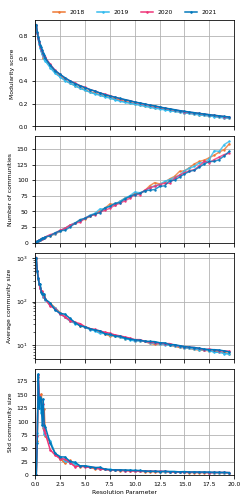

In [39]:
#Visualize statistics
colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    


cm = 1/2.54
fig,ax = plt.subplots(ncols=1,nrows=4,figsize=(8.7*cm,2*8.7*cm),sharex=True)
fig.text(0.5, 0.00, 'Resolution Parameter', ha='center')

ax[0].set(ylabel="Modularity score",yscale="linear")
ax[1].set(ylabel="Number of communities")
# # ax[0,1].set(xlabel="Resolution parameter", ylabel="Median community size")
ax[2].set( ylabel="Average community size",yscale="log")
ax[3].set( ylabel="Std community size",yscale="linear")
for year, data in communities_statistics.items():
    ax[0].plot(resolutions[1:],data["Modularity_score"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
    ax[1].plot(resolutions[1:],data["N_communities"][1:],label=year, marker='o', ms=1.5,alpha=0.8, color = colors[int(year)])
    # ax[0,1].plot(resolutions,data["Median_comm_size"],label=year, marker='o', ms=3, color = colors[int(year)])
    ax[2].plot(resolutions[1:],data["Avg_comm_size"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
    ax[3].plot(resolutions[1:],data["Sigma_comm_size"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
             

for a in ax.flatten():
    a.grid()
    a.set(xlim=(0,20),ylim=(0,a.get_ylim()[1]))
    # a.set_xticks(a.get_xticks())
    # a.set_xticklabels(a.get_xticklabels(),fontdict={"fontsize":6})
    # a.legend()
# ax[0,0].grid()
# ax[0,1].grid()
ax[0].legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
# ax[0,1].legend()
plt.tight_layout()
plt.savefig("louvain_community_statistics.pdf")
# plt.savefig("modularity_community_statistics.png",dpi=200)


In [40]:
from scipy.stats import linregress

fits = []
for year, data in communities_statistics.items():
    fits.append(linregress(resolutions, data["N_communities"]))
    print(fits[-1])
    # print(f"\\SI{{{fits[-1].slope}({fits[-1].stderr})}}{{}} & \\SI{{{fits[-1].intercept}({fits[-1].intercept_stderr})}}{{}} & {fits[-1].rvalue}\\\\")#, str(fits[-1].intercept),str(fits[-1].pvalue)]))

LinregressResult(slope=7.774360613250914, intercept=0.1229566328987417, rvalue=0.9992751678383301, pvalue=5.943379112536314e-67, stderr=0.043667234053082316, intercept_stderr=0.451767733691317)
LinregressResult(slope=7.774308078906587, intercept=0.12338785230843285, rvalue=0.9981082650256801, pvalue=2.2439500020859573e-57, stderr=0.0706065243761133, intercept_stderr=0.7304733215399496)
LinregressResult(slope=7.332708758350773, intercept=1.227348941870737, rvalue=0.9995791270144984, pvalue=2.2153282113105748e-72, stderr=0.031377126170605965, intercept_stderr=0.32461806860974274)
LinregressResult(slope=7.2466881473763465, intercept=1.537601456952487, rvalue=0.9990770604281887, pvalue=1.536914785233724e-64, stderr=0.045937046664046605, intercept_stderr=0.47525051480616365)


In [7]:
# Find matching communities
def enumerate_simmilarity(d1,d2):
    scores = []
    simmilarity = lambda d,d1: len(d1.keys() & d.keys()) * sum([d1[c]*d[c]/(1+abs(d1[c]-d[c])) for c in (d1.keys() & d.keys())])
    for d in d1:
        scores.append([simmilarity(d,dd) for dd in d2])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(d1),-1)
        
    for i in range(len(d1)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1
        scores[:,index[1]] = -1
     
    return list(zip(best,d1))


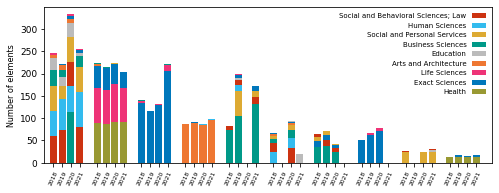

In [9]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(17.8*cm,7*cm))

areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["area"] for y in x] for x in louvain_comms[G.graph["year"]]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

# ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")

In [51]:
# Find matching communities NEW
def enumerate_simmilarity(enum, min_courses, max_courses):
    scores = []
    simmilarity = lambda x, y: len(set(x) & set(y))**2 /(1 + len(set(x) - set(y)) + len(set(y) - set(x)))
    for comm1 in min_courses:
        scores.append([simmilarity(comm1,comm2) for comm2 in max_courses])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(min_courses),-1)
        
    for i in range(len(min_courses)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1e6
        scores[:,index[1]] = -1e6
     
    return list(zip(best,enum))

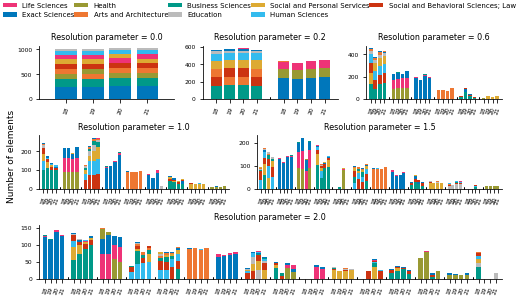

In [52]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54

mosaic = """
EEEAAABBB
CCCCFFFFF
DDDDDDDDD
"""
fig = plt.figure(constrained_layout=False, figsize=(17.8*cm,3*3.5*cm))
ax_dict = fig.subplot_mosaic(mosaic)

for ax,resolution_index in zip(ax_dict.values(),[0,2,6,10,11,12]):
    areas_in_comm = {}
    for G in networks:
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[G.graph["year"]][resolution_index]]
        areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]


    max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
    max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

    max_comms = communities_by_resolution[max_idx][resolution_index]
    
    for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
        if year == max_idx: 
            areas_in_comm[year] = max_comms_enum
            continue
        areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm.values())):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    years = list(range(18,22))*len(max_comms)
    idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
    idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        

    ax.set_xticks(idx_minor,minor=True)
    ax.set_xticks(idx,minor=False)
    ax.tick_params(which="minor",axis="x",direction="in")
    ax.set_xticklabels(years, rotation=70, fontdict={"fontsize":6})

    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.set_title(f"Resolution parameter = {resolutions[resolution_index]:.1f}", fontdict={"fontsize":8})

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.savefig("images/louvain_communities_by_field.pdf")